# <center> Microlocal analysis of the convolutional ReLU layers in LPD </center>

## Utilitary libraries

In [1]:
%matplotlib inline
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
import sys
sys.path.append("../../WF_inpaint/")

In [3]:
# Import the needed modules
from data.data_factory import random_realphantom
from ellipse.ellipseWF_factory import plot_WF, WFupdate, WFupdate_sino

import matplotlib.pyplot as plt
import numpy.random as rnd
import numpy as np
import odl
import matplotlib.pyplot as plt

../../WF_inpaint/data/data_factory.py:7: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/homes/extern/andrade/store/miniconda3/envs/tf_gpu/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/homes/extern/andrade/store/miniconda3/envs/tf_gpu/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/homes/extern/andrade/store/miniconda3/envs/tf_gpu/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/homes/extern/andrade/store/miniconda3/envs/tf_gpu/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/homes/extern/andra

../../WF_inpaint/realphantom/realphantomWF_factory.py:9: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/homes/extern/andrade/store/miniconda3/envs/tf_gpu/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/homes/extern/andrade/store/miniconda3/envs/tf_gpu/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/homes/extern/andrade/store/miniconda3/envs/tf_gpu/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/homes/extern/andrade/store/miniconda3/envs/tf_gpu/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/ho

In [4]:
import os
import adler
adler.util.gpu.setup_one_gpu(0)

Warning, GPU setup must happen before importing ASTRA
Picking GPU 0


In [5]:
from adler.odl.phantom import random_phantom
from adler.tensorflow import prelu, cosine_decay

In [6]:
import tensorflow as tf
import numpy as np
import odl
import odl.contrib.tensorflow

In [7]:
np.random.seed(0)
#name = os.path.splitext(os.path.basename(__file__))[0]
name = os.path.splitext(os.getcwd())[0]+'/checkpoints'

In [8]:
sess = tf.InteractiveSession()

## Radon transform

In [9]:
size = 256
lowd = 40

In [10]:
from ray_transform.canon_relation import (point_img2sino, class_img2sino, CanRel_img2sino, 
                                         point_sino2img, CanRel_sino2img)

In [11]:
# Create ODL data structures
space = odl.uniform_discr([-int(size/2), -int(size/2)], [int(size/2), int(size/2)], [size, size],
                          dtype='float32')

In [12]:
# Full dose radon transform
geometry = odl.tomo.parallel_beam_geometry(space, num_angles=180)
operator = odl.tomo.RayTransform(space, geometry)
opnorm = odl.power_method_opnorm(operator)
operator = (1 / opnorm) * operator

In [13]:
# Low dose radon transform
geometry_lowd = odl.tomo.parallel_beam_geometry(space, num_angles=lowd)
operator_lowd = odl.tomo.RayTransform(space, geometry_lowd)
opnorm_lowd = odl.power_method_opnorm(operator_lowd)
operator_lowd = (1 / opnorm_lowd) * operator_lowd

## Data generator for CT recon

In [14]:
size = 256
nClasses = 180
lowd = 40
nRegions = np.random.randint(5,10)
npoints_max = np.random.randint(8,15)

In [15]:
batch_size = 5
n_iter = 10
n_primal = 5
n_dual = 5

In [16]:
def generate_data_CT(validation=False):
    """Generate a set of random data."""
    if validation:
        n_generate = 1
    else: 
        n_generate = batch_size

    y_arr = np.empty((n_generate, operator_lowd.range.shape[0], operator_lowd.range.shape[1], 1), dtype='float32')
    x_true_arr = np.empty((n_generate, space.shape[0], space.shape[1], 1), dtype='float32')

    for i in range(n_generate):
        if validation:
            phantom = odl.phantom.shepp_logan(space, True)
        else:
            phantom, _, _,  _ = random_realphantom(size, nRegions, npoints_max, nClasses)
        data = operator_lowd(phantom)
        noisy_data = data + odl.phantom.white_noise(operator_lowd.range) * np.mean(np.abs(data)) * 0.05

        x_true_arr[i, ..., 0] = phantom
        y_arr[i, ..., 0] = noisy_data

    return y_arr, x_true_arr

In [17]:
y_arr, x_true_arr = generate_data_CT()

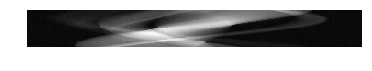

In [18]:
plt.figure(figsize = (6,6))
plt.axis("off")
plt.imshow(y_arr[0,:,:,0], cmap="gray")

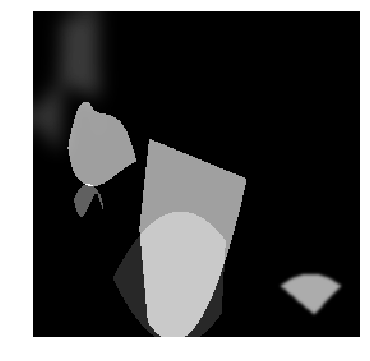

In [19]:
plt.figure(figsize = (6,6))
plt.axis("off")
plt.imshow(x_true_arr[0,:,:,0], cmap="gray")

## Evaluate primal dual

In [20]:
# Create tensorflow layer from odl operator
odl_op_layer = odl.contrib.tensorflow.as_tensorflow_layer(operator_lowd,
                                                          'RayTransform')
odl_op_layer_adjoint = odl.contrib.tensorflow.as_tensorflow_layer(operator_lowd.adjoint,
                                                                  'RayTransformAdjoint')

In [21]:
with tf.name_scope('placeholders'):
    x_true = tf.placeholder(tf.float32, shape=[None, size, size, 1], name="x_true")
    y_rt = tf.placeholder(tf.float32, shape=[None, operator_lowd.range.shape[0], operator_lowd.range.shape[1], 1], name="y_rt")
    is_training = tf.placeholder(tf.bool, shape=(), name='is_training')

In [22]:
def apply_conv(x, filters=32):
    return tf.layers.conv2d(x, filters=filters, kernel_size=3, padding='SAME',
                            kernel_initializer=tf.contrib.layers.xavier_initializer(), use_bias=False)

In [23]:
primal_values = []
dual_values = []

In [24]:
relu = tf.nn.relu

In [25]:
with tf.name_scope('tomography'):
    with tf.name_scope('initial_values'):
        primal = tf.concat([tf.zeros_like(x_true)] * n_primal, axis=-1)
        dual = tf.concat([tf.zeros_like(y_rt)] * n_dual, axis=-1)

    for i in range(n_iter):
        with tf.variable_scope('dual_iterate_{}'.format(i)):
            evalop = odl_op_layer(primal[..., 1:2])
            update = tf.concat([dual, evalop, y_rt], axis=-1)

            #update = prelu(apply_conv(update), name='prelu_1')
            #update = prelu(apply_conv(update), name='prelu_2')
            update = relu(apply_conv(update), name='relu_1')
            update = relu(apply_conv(update), name='relu_2')            
            update = apply_conv(update, filters=n_dual)
            dual = dual + update

        with tf.variable_scope('primal_iterate_{}'.format(i)):
            evalop = odl_op_layer_adjoint(dual[..., 0:1])
            update = tf.concat([primal, evalop], axis=-1)

            update = relu(apply_conv(update), name='relu_1')
            update = relu(apply_conv(update), name='relu_2')
            update = apply_conv(update, filters=n_primal)
            primal = primal + update
        
        primal_values.append(primal)
        dual_values.append(dual)

    x_result = primal[..., 0:1]

In [26]:
# Initialize all TF variables
sess.run(tf.global_variables_initializer())

In [27]:
ckp_name = name+'_lpd_nobias/checkpoints'

In [28]:
adler.tensorflow.util.default_checkpoint_path(ckp_name)

'/store/kepler/datastore/andrade/GitHub_repos/Joint_CTWF_Recon/Microcanonical_NN/Tensorflow_microlocal/checkpoints_lpd_nobias/checkpoints.ckpt'

In [29]:
# Add op to save and restore
saver = tf.train.Saver()

if 1:
    saver.restore(sess,
                  adler.tensorflow.util.default_checkpoint_path(ckp_name))

INFO:tensorflow:Restoring parameters from /store/kepler/datastore/andrade/GitHub_repos/Joint_CTWF_Recon/Microcanonical_NN/Tensorflow_microlocal/checkpoints_lpd_nobias/checkpoints.ckpt


In [30]:
# Generate validation data
y_arr_validate, x_true_arr_validate = generate_data_CT(validation=True)

primal_values_result, dual_values_result = sess.run([primal_values, dual_values],
                      feed_dict={x_true: x_true_arr_validate,
                                 y_rt: y_arr_validate,
                                 is_training: False})

In [31]:
import matplotlib.pyplot as plt
from skimage.measure import compare_ssim as ssim
from skimage.measure import compare_psnr as psnr

print(ssim(primal_values_result[-1][0, ..., 0], x_true_arr_validate[0, ..., 0]))
print(psnr(primal_values_result[-1][0, ..., 0], x_true_arr_validate[0, ..., 0], data_range=1))

0.986987719406
34.1344250283


/homes/extern/andrade/store/miniconda3/envs/tf_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  """
/homes/extern/andrade/store/miniconda3/envs/tf_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  


(-0.5, 364.5, 39.5, -0.5)

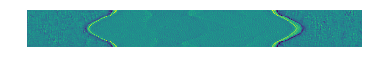

In [32]:
plt.figure(figsize=(6,6))
plt.imshow(dual_values_result[3][0, ..., 0])
plt.axis('off')

(-0.5, 255.5, 255.5, -0.5)

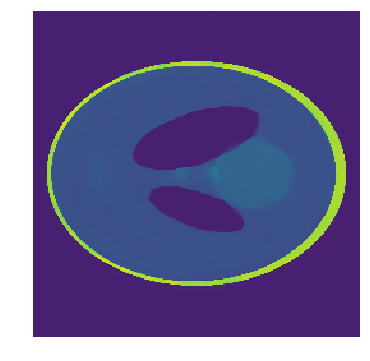

In [33]:
plt.figure(figsize=(6,6))
plt.imshow(primal_values_result[9][0, ..., 0])
plt.axis('off')

## In this case we have 10 LPD conv_ResNet subnetworks representing each Dual/Primal step

In [34]:
tf.global_variables()

[<tf.Variable 'dual_iterate_0/conv2d/kernel:0' shape=(3, 3, 7, 32) dtype=float32_ref>,
 <tf.Variable 'dual_iterate_0/conv2d_1/kernel:0' shape=(3, 3, 32, 32) dtype=float32_ref>,
 <tf.Variable 'dual_iterate_0/conv2d_2/kernel:0' shape=(3, 3, 32, 5) dtype=float32_ref>,
 <tf.Variable 'primal_iterate_0/conv2d/kernel:0' shape=(3, 3, 6, 32) dtype=float32_ref>,
 <tf.Variable 'primal_iterate_0/conv2d_1/kernel:0' shape=(3, 3, 32, 32) dtype=float32_ref>,
 <tf.Variable 'primal_iterate_0/conv2d_2/kernel:0' shape=(3, 3, 32, 5) dtype=float32_ref>,
 <tf.Variable 'dual_iterate_1/conv2d/kernel:0' shape=(3, 3, 7, 32) dtype=float32_ref>,
 <tf.Variable 'dual_iterate_1/conv2d_1/kernel:0' shape=(3, 3, 32, 32) dtype=float32_ref>,
 <tf.Variable 'dual_iterate_1/conv2d_2/kernel:0' shape=(3, 3, 32, 5) dtype=float32_ref>,
 <tf.Variable 'primal_iterate_1/conv2d/kernel:0' shape=(3, 3, 6, 32) dtype=float32_ref>,
 <tf.Variable 'primal_iterate_1/conv2d_1/kernel:0' shape=(3, 3, 32, 32) dtype=float32_ref>,
 <tf.Variable '

In [35]:
# Get access to the graph
gr = tf.get_default_graph()

In [36]:
names_variables = [variable.name for variable in tf.global_variables()]

## Singularity propagation along the LPD iterations

### Generate data with wavefront set

In [37]:
size = 256
nClasses = 180
lowd = 40

### Phantom sinogram

In [38]:
nRegions = np.random.randint(5,10)
npoints_max = np.random.randint(8,15)
realphantom, WFpoints, WFclasses,  WFimage = random_realphantom(size, nRegions, npoints_max, nClasses)

# Compute low dose WF image
angles_lowd = np.array([i for i in range(0,180,int(180/lowd))])
# Extracting the wavefront set orientations in the low dose
angles_gt = (np.array(WFclasses).astype(int)[:,0]-1)
angles_gt_lowd = np.array([angle in angles_lowd for angle in angles_gt])
# Generating the new WFpoints and classes
WFpoints_lowd = WFpoints[angles_gt_lowd]
WFclasses_lowd = list(np.array(WFclasses)[angles_gt_lowd])
# Generating the low dose WFimage
WFimage_lowd = np.zeros([size,size])
WFimage_lowd = WFupdate(WFpoints_lowd, WFclasses_lowd, WFimage_lowd)

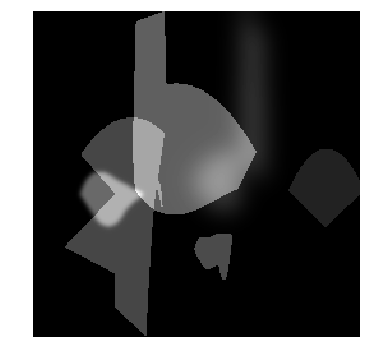

In [39]:
plt.figure(figsize = (6,6))
plt.axis("off")
plt.imshow(realphantom, cmap="gray")

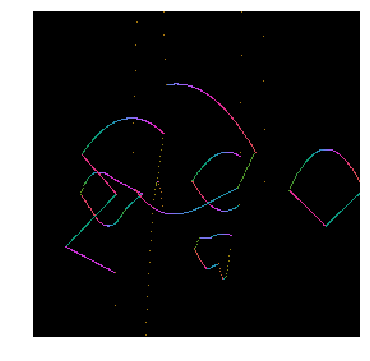

In [40]:
plt.figure(figsize = (6,6))
plt.axis("off")
plot_WF(WFimage)

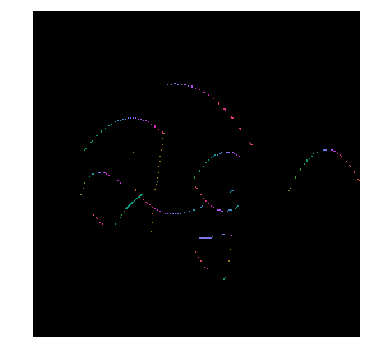

In [41]:
plt.figure(figsize = (6,6))
plt.axis("off")
plot_WF(WFimage_lowd)

In [42]:
# Full dose sinogram
sinogram = np.array(operator(space.element(realphantom)))
sinogram_shape = sinogram.shape
WFpoints_sino, WFclasses_sino = CanRel_img2sino(WFpoints, WFclasses, size, sinogram_shape, num_angles = 180)
WFimage_sino = np.zeros(sinogram.shape)
WFimage_sino = WFupdate_sino(WFpoints_sino, WFclasses_sino, WFimage_sino)

In [43]:
# Low dose sinogram
sinogram_lowd= np.array(operator_lowd(space.element(realphantom)))
sinogram_shape_lowd = sinogram_lowd.shape
WFpoints_sino_lowd, WFclasses_sino_lowd = CanRel_img2sino(WFpoints_lowd, WFclasses_lowd, size, sinogram_shape_lowd, num_angles = 180)
WFpoints_sino_lowd[:,1] = lowd* WFpoints_sino_lowd[:,1]/180
WFimage_sino_lowd = np.zeros(sinogram_lowd.shape)
WFimage_sino_lowd = WFupdate_sino(WFpoints_sino_lowd, WFclasses_sino_lowd, WFimage_sino_lowd)

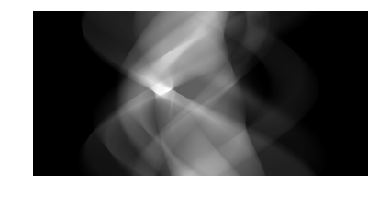

In [44]:
plt.figure(figsize = (6,6))
plt.axis("off")
plt.imshow(sinogram , cmap="gray")

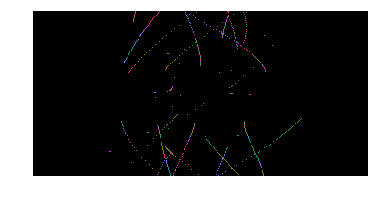

In [45]:
plt.figure(figsize = (6,6))
plt.axis("off")
plot_WF((180*WFimage_sino)%180)

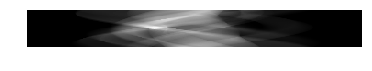

In [46]:
plt.figure(figsize = (6,6))
plt.axis("off")
plt.imshow(sinogram_lowd , cmap="gray")

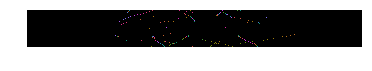

In [47]:
plt.figure(figsize = (6,6))
plt.axis("off")
plot_WF((100*WFimage_sino_lowd)%180)

### Evaluation of that image in the layers

In [48]:
tf.global_variables()

[<tf.Variable 'dual_iterate_0/conv2d/kernel:0' shape=(3, 3, 7, 32) dtype=float32_ref>,
 <tf.Variable 'dual_iterate_0/conv2d_1/kernel:0' shape=(3, 3, 32, 32) dtype=float32_ref>,
 <tf.Variable 'dual_iterate_0/conv2d_2/kernel:0' shape=(3, 3, 32, 5) dtype=float32_ref>,
 <tf.Variable 'primal_iterate_0/conv2d/kernel:0' shape=(3, 3, 6, 32) dtype=float32_ref>,
 <tf.Variable 'primal_iterate_0/conv2d_1/kernel:0' shape=(3, 3, 32, 32) dtype=float32_ref>,
 <tf.Variable 'primal_iterate_0/conv2d_2/kernel:0' shape=(3, 3, 32, 5) dtype=float32_ref>,
 <tf.Variable 'dual_iterate_1/conv2d/kernel:0' shape=(3, 3, 7, 32) dtype=float32_ref>,
 <tf.Variable 'dual_iterate_1/conv2d_1/kernel:0' shape=(3, 3, 32, 32) dtype=float32_ref>,
 <tf.Variable 'dual_iterate_1/conv2d_2/kernel:0' shape=(3, 3, 32, 5) dtype=float32_ref>,
 <tf.Variable 'primal_iterate_1/conv2d/kernel:0' shape=(3, 3, 6, 32) dtype=float32_ref>,
 <tf.Variable 'primal_iterate_1/conv2d_1/kernel:0' shape=(3, 3, 32, 32) dtype=float32_ref>,
 <tf.Variable '

In [49]:
iterate = 0
conv_layer = 0
dual = True

In [50]:
if dual== True:
    ld = 'dual'
    shape = operator_lowd.range.shape
else:
    ld = 'primal'
    shape = operator_lowd.domain.shape

In [51]:
if conv_layer == 0:
    conv_name = '/conv2d/'
else:
    conv_name = '/conv2d_'+str(conv_layer)+'/'

In [55]:
name_kernel = (ld+'_iterate_'+str(iterate)+conv_name+'kernel:0')
#name_bias = (ld+'_iterate_'+str(iterate)+conv_name+'bias:0')

In [56]:
kernels = gr.get_tensor_by_name(name_kernel)
#bias = gr.get_tensor_by_name(name_bias)

### Evaluating the layer

In [57]:
sinogram_lowd_tf = tf.constant(sinogram_lowd[np.newaxis, :,:, np.newaxis],
                              dtype = tf.float32)
realphantom_tf = tf.constant(realphantom[np.newaxis, :,:, np.newaxis],
                              dtype = tf.float32);

In [58]:
x_true = realphantom_tf 
y_rt = sinogr1am_lowd_tf;

In [59]:
primal = tf.concat([tf.zeros_like(x_true)] * n_primal, axis=-1)
dual = tf.concat([tf.zeros_like(y_rt)] * n_dual, axis=-1)

In [60]:
evalop = odl_op_layer(primal[..., 1:2])

In [61]:
update = tf.concat([dual, evalop, y_rt], axis=-1)

In [62]:
conv_kernel_1 = tf.nn.conv2d(update, kernels, [1, 1, 1, 1], padding='SAME')
#conv_bias_1 = tf.nn.bias_add(conv_kernel_1, bias)
conv_relu_1 = relu(conv_kernel_1)

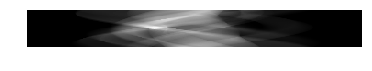

In [63]:
plt.figure(figsize = (6,6))
plt.axis("off")
plt.imshow(update.eval()[0,:,:,6], cmap = "gray")

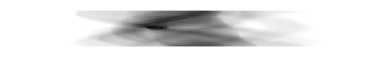

In [64]:
plt.figure(figsize = (6,6))
plt.axis("off")
plt.imshow(conv_kernel_1.eval()[0,:,:,6], cmap = "gray")

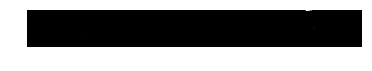

In [67]:
plt.figure(figsize = (6,6))
plt.axis("off")
plt.imshow(conv_relu_1.eval()[0,:,:,6], cmap = "gray")

## Analysis of wavefront set of the ReLU layer in the dual steps                                                         

The convolutional neural networks will preserve the singularities wherever the symbol is not zero. In most of the cases everywhere. 

The ReLU layer will delete certain singularities according with the analysis in the script. 

Let $f$ be the biased output of the convolutional layer, the ReLU activation function is applied on $f$.

In [68]:
f = conv_kernel_1.eval()

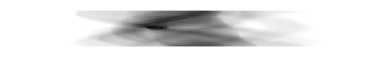

In [69]:
plt.figure(figsize = (6,6))
plt.axis("off")
plt.imshow(f[0,:,:,6], cmap = "gray")

Since $\text{ReLU}(f) = H(f) f$, we need to compute first the wavefront set $WF(H(f))$. 

### Computing $WF(H(f))$

The ReLU function can be seen as the multiplication $\text{ReLU}(y) = H(y) y$, therefore $\text{ReLU}(f)(x)=H(f(x))f(x)$ where

$$
H(f(x)) = 
\begin{cases}
f(x) & \text{ if } f(x)>0 \\
0 & \text{ if } f(x) \leq 0
\end{cases}
$$

In [70]:
Hf = np.heaviside(f,0)

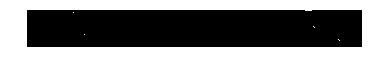

In [71]:
plt.figure(figsize = (6,6))
plt.axis("off")
plt.imshow(Hf[0,:,:,6], cmap = "gray")

As we explained in the script, we can compute the wavefront set of $H(f)$ using the gradient. 

We know that the weak gradient of $H(f)$ is given by the relation
$$
\int_{\mathbb{R}^2}\nabla H(f)(x)\cdot \varphi (x)dx = -\oint_{\partial \Omega} \varphi(x)\cdot n_{\partial\Omega}(x)dS(x)
$$

where $n_{\partial\Omega}(x)$ is the outward normal to the boundary surface $\partial\Omega$, where $\Omega= \text{supp}_+(f)$ (the non-negative support).

Now, the $f$ has 32 channels and is also batched, we can apply our analysis to each channel individually and batch element. We compute the gradient with the same operator than in the differential approximation of the convolutional operation.

In [72]:
# Channels where Hf is non zero
channels_nonzero = np.where(Hf!=0)[3]

In [73]:
from scipy import ndimage

In [74]:
# Function that computes the gradient for each channel
def grad_channel_batch(f):
    fxs = np.zeros(f.shape)
    fys = fxs.copy(f.shape)
    for batch in range(fxs.shape[0]):
        for channel in range(fxs.shape[3]):
            fi = f[batch,:,:,channel]
            fxs[batch,:,:,channel] = ndimage.sobel(fi, axis= 0, mode='constant')
            fys[batch,:,:,channel] = ndimage.sobel(fi, axis= 1, mode='constant')
    return fxs, fys

In [75]:
# Compute WF set from gradient
def WF_grad(fx,fy):
    WFset = np.zeros(fx.shape)
    for i in range(fx.shape[0]):
        for j in range(fx.shape[1]):
            if fx[i,j] == 0:
                WFset[i,j] = 0
            else:
                WFset[i,j] = 180*np.arctan(fy[i,j]/fx[i,j])/(2*np.pi)
    return WFimage

In [154]:
# Compute WF set from gradient for mutiple channels
def WF_grad_channel_batch(fxs, fys):
    WFset = np.zeros(fxs.shape)
    for batch in range(fxs.shape[0]):
        for channel in range(fxs.shape[3]):
            fx = fxs[batch,:,:,channel]
            fy = fys[batch,:,:,channel]
            WFset[batch,:,:,channel] = WF_grad(fx,fy)
    return WFset

In [152]:
fxs, fys = grad_channel_batch(Hf)

/homes/extern/andrade/store/miniconda3/envs/tf_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
  after removing the cwd from sys.path.


In [77]:
batch = 0
channel = channels_nonzero[2]
fi = f[batch,:,:,channel]
Hfi =  Hf[batch,:,:,channel]
fx = fxs[batch,:,:,channel]
fy = fys[batch,:,:,channel]
edges = np.hypot(fx,fy)
WFimage = WF_grad(fx,fy)

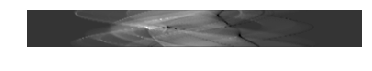

In [78]:
plt.figure(figsize = (6,6))
plt.axis("off")
plt.imshow(fi, cmap = "gray")

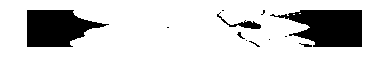

In [79]:
plt.figure(figsize = (6,6))
plt.axis("off")
plt.imshow(Hfi, cmap = "gray")

### The singular support and wavefront set will be

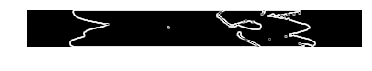

In [80]:
plt.figure(figsize = (6,6))
plt.axis("off")
plt.imshow(edges, cmap="gray")

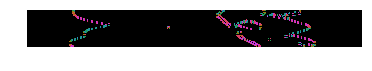

In [81]:
plt.figure(figsize = (6,6))
plt.axis("off")
plot_WF(WFimage)

### Computing $WF(\text{ReLU}(f))$

In [82]:
def ReLU(x):
    return np.array([max(xi,0) for xi in x])

In [83]:
def ReLU2(f):
    ReLUf=np.zeros(f.shape);
    for i in range(f.shape[0]):
        for j in range(f.shape[1]):
            ReLUf[i,j] = max(f[i,j],0)
    return ReLUf

In [84]:
def ReLU2_channel_batch(f):
    ReLUfs = np.zeros(f.shape)
    for batch in range(fxs.shape[0]):
        for channel in range(fxs.shape[3]):
            fi = f[batch,:,:,channel]
            ReLUfs[batch,:,:,channel] = ReLU2(fi);
    return ReLUfs

In [85]:
ReLUfs = ReLU2_channel_batch(f)

In [86]:
batch = 0
channel = channels_nonzero[2]
fi = f[batch,:,:,channel]
ReLUfi =  ReLUfs[batch,:,:,channel]

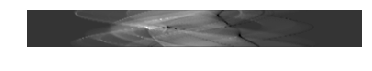

In [87]:
plt.figure(figsize = (6,6))
plt.axis("off")
plt.imshow(fi, cmap = "gray")

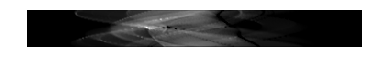

In [88]:
plt.figure(figsize = (6,6))
plt.axis("off")
plt.imshow(ReLUfi, cmap = "gray")

In [89]:
fxs, fys = grad_channel_batch(Hf)
WFimage_Hf = WF_grad(fx,fy)

/homes/extern/andrade/store/miniconda3/envs/tf_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
  after removing the cwd from sys.path.


The Wavefront set $WF(\text{ReLU}(f))$ will be the sum of the wavefront sets $WF(f)$ and $WF(H(f))$ without the regular points of each.

In [90]:
WFimage_f = WFimage_sino_lowd;

In [91]:
WFimage_ReLUf = (WFimage_Hf+WFimage_f)%180

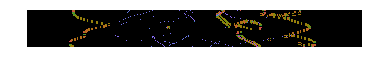

In [92]:
plt.figure(figsize = (6,6))
plt.axis("off")
plot_WF(WFimage_ReLUf)

## Analysis of wavefront set of the ReLU layer in the primal step

Extracting the convolutional kernel and bias

In [93]:
iterate = 0
conv_layer = 0
dual = False

In [94]:
if dual== True:
    ld = 'dual'
    shape = operator_lowd.range.shape
else:
    ld = 'primal'
    shape = operator_lowd.domain.shape

In [95]:
if conv_layer == 0:
    conv_name = '/conv2d/'
else:
    conv_name = '/conv2d_'+str(conv_layer)+'/'

In [99]:
name_kernel = (ld+'_iterate_'+str(iterate)+conv_name+'kernel:0')
#name_bias = (ld+'_iterate_'+str(iterate)+conv_name+'bias:0')

In [100]:
kernels = gr.get_tensor_by_name(name_kernel)
#bias = gr.get_tensor_by_name(name_bias)

In [101]:
name_kernel

'primal_iterate_0/conv2d/kernel:0'

In [102]:
evalop = odl_op_layer_adjoint(y_rt)

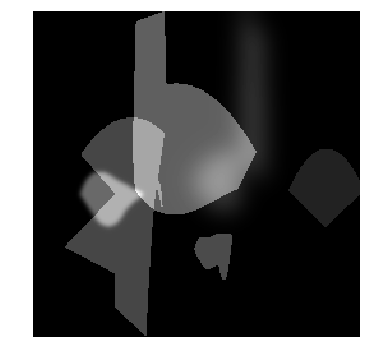

In [103]:
plt.figure(figsize = (6,6))
plt.axis("off")
plt.imshow(realphantom, cmap="gray")

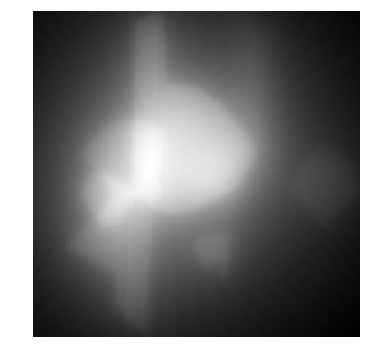

In [104]:
plt.figure(figsize = (6,6))
plt.axis("off")
plt.imshow(evalop.eval()[0,:,:,0], cmap = "gray")

In [105]:
update = tf.concat([primal, evalop], axis=-1)

In [106]:
conv_kernel_1 = tf.nn.conv2d(update, kernels, [1, 1, 1, 1], padding='SAME')
#conv_bias_1 = tf.nn.bias_add(conv_kernel_1, bias)
conv_relu_1 = relu(conv_kernel_1)

In [107]:
update.eval().shape

(1, 256, 256, 6)

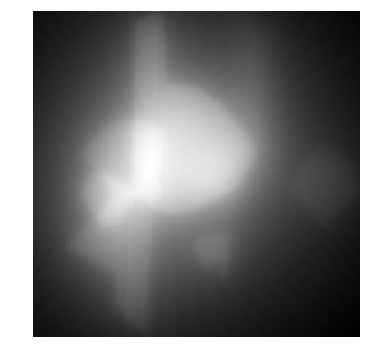

In [108]:
plt.figure(figsize = (6,6))
plt.axis("off")
plt.imshow(update.eval()[0,:,:,5], cmap = "gray")

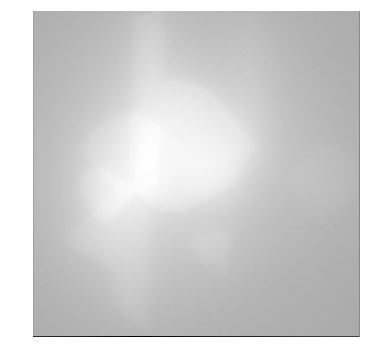

In [109]:
plt.figure(figsize = (6,6))
plt.axis("off")
plt.imshow(conv_kernel_1.eval()[0,:,:,5], cmap = "gray")

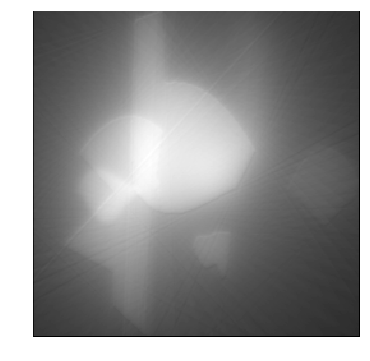

In [111]:
plt.figure(figsize = (6,6))
plt.axis("off")
plt.imshow(conv_relu_1.eval()[0,:,:,5], cmap = "gray")

In [113]:
f = conv_relu_1.eval()

In [114]:
Hf = np.heaviside(f,0)
ReLUfs = ReLU2_channel_batch(f)
channels_nonzero = np.where(Hf!=0)[3]

In [115]:
fxs, fys = grad_channel_batch(Hf)

/homes/extern/andrade/store/miniconda3/envs/tf_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
  after removing the cwd from sys.path.


In [116]:
batch = 0
channel = channels_nonzero[2]
fi = f[batch,:,:,channel]
Hfi =  Hf[batch,:,:,channel]
ReLUfi = ReLUfs[batch,:,:,channel]
fx = fxs[batch,:,:,channel]
fy = fys[batch,:,:,channel]
edges = np.hypot(fx,fy)
WFimage_Hf = WF_grad(fx,fy)

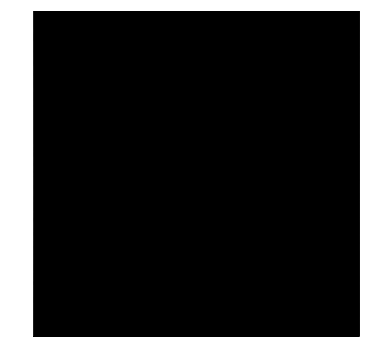

In [117]:
plt.figure(figsize = (6,6))
plt.axis("off")
plt.imshow(fi, cmap = "gray")

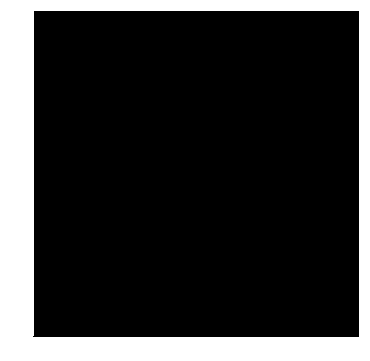

In [118]:
plt.figure(figsize = (6,6))
plt.axis("off")
plt.imshow(Hfi, cmap = "gray")

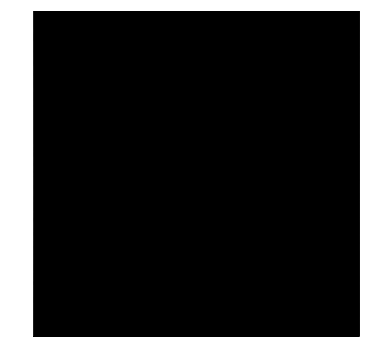

In [119]:
plt.figure(figsize = (6,6))
plt.axis("off")
plt.imshow(ReLUfi, cmap = "gray")

In [120]:
WFimage_f = WFimage_lowd

In [121]:
WFimage_ReLUf = (WFimage_Hf+WFimage_f)%180

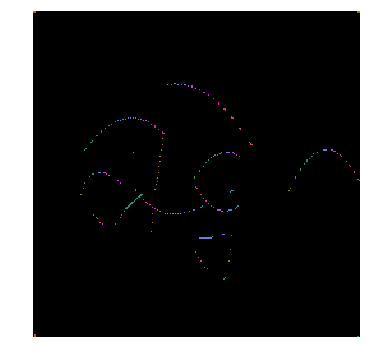

In [122]:
plt.figure(figsize = (6,6))
plt.axis("off")
plot_WF(WFimage_ReLUf)

### Functional approach

In [183]:
## Defining intial values

# Initial values of the recon and data
x_true = realphantom_tf 
y_rt = sinogram_lowd_tf;

# Initial value of the primal, dual, update, evalop
primal = tf.concat([tf.zeros_like(x_true)] * n_primal, axis=-1)
dual = tf.concat([tf.zeros_like(y_rt)] * n_dual, axis=-1)
evalop = odl_op_layer(primal[..., 1:2])
update = tf.concat([dual, evalop, y_rt], axis=-1)

# Initial value of WFset
WFset = WFimage_sino_lowd

In [125]:
iterate = 0
conv_layer = 0
dual = True

In [126]:
## Defining shape and name of the layer
if dual== True:
    ld = 'dual'
    shape = operator_lowd.range.shape
else:
    ld = 'primal'
    shape = operator_lowd.domain.shape
    
if conv_layer == 0:
    conv_name = '/conv2d/'
else:
    conv_name = '/conv2d_'+str(conv_layer)+'/'
    
# Defining name of the kernel
name_kernel = (ld+'_iterate_'+str(iterate)+conv_name+'kernel:0')

# Load the kernels value
kernels = gr.get_tensor_by_name(name_kernel)

In [127]:
# Apply the convolutional layer to the update
conv_kernel_1 = tf.nn.conv2d(update, kernels, [1, 1, 1, 1], padding='SAME')
conv_relu_1 = relu(conv_kernel_1)

In [139]:
# Evaluate convolutional kernel
f = conv_kernel_1.eval()

# Apply heaviside function
Hf = np.heaviside(f,0)

In [155]:
# Apply ReLU output for each batch and channel
ReLUfs = ReLU2_channel_batch(f)

# Computing the Heavisde part of the Wavefrontset 
fxs, fys = grad_channel_batch(Hf)
WFset_Hf = WF_grad_channel_batch(fxs, fys)

/homes/extern/andrade/store/miniconda3/envs/tf_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
  after removing the cwd from sys.path.


In [187]:
# Wavefront set of the convolutional output
WFset_f = WFset;
n_batch = WFset_Hf.shape[0]
n_channels =  WFset_Hf.shape[3]
WFset_f = np.repeat(WFset_f[np.newaxis,:,:],n_batch, axis=0)
WFset_f = np.repeat(WFset_f[:,:,:, np.newaxis],n_channels, axis=3)

In [188]:
# Computing the Wavefrnt set of the ReLU layer
WFset_ReLUf = (WFset_Hf+WFset_f)%180

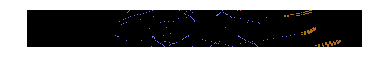

In [191]:
plt.figure(figsize = (6,6))
plt.axis("off")
plot_WF(WFset_ReLUf[0,:,:,0])

## Function

In [194]:
iterate = 0
conv_layer = 0
dual = True
update = update
radon = operator_lowd
n_batch = WFset_Hf.shape[0]
n_channels =  32
WFset_f = np.repeat(WFset[np.newaxis,:,:],n_batch, axis=0)
WFset_f = np.repeat(WFset_f[:,:,:, np.newaxis],n_channels, axis=3)

In [195]:
def ReLU_microlocal(update, radon, WFset_f, iterate, conv_layer, dual):
    ## Defining shape and name of the layer
    if dual== True:
        ld = 'dual'
        shape = radon.range.shape
    else:
        ld = 'primal'
        shape = radon.domain.shape

    if conv_layer == 0:
        conv_name = '/conv2d/'
    else:
        conv_name = '/conv2d_'+str(conv_layer)+'/'

    # Defining name of the kernel
    name_kernel = (ld+'_iterate_'+str(iterate)+conv_name+'kernel:0')

    # Load the kernels value
    kernels = gr.get_tensor_by_name(name_kernel)
    
    # Apply the convolutional layer to the update
    conv_kernel_1 = tf.nn.conv2d(update, kernels, [1, 1, 1, 1], padding='SAME')
    conv_relu_1 = relu(conv_kernel_1)
    # Evaluate convolutional kernel
    f = conv_kernel_1.eval()

    # Apply heaviside function
    Hf = np.heaviside(f,0)
    
    # Apply ReLU output for each batch and channel
    ReLUfs = ReLU2_channel_batch(f)

    # Computing the Heavisde part of the Wavefrontset 
    fxs, fys = grad_channel_batch(Hf)
    WFset_Hf = WF_grad_channel_batch(fxs, fys)
    
    # Computing the Wavefrnt set of the ReLU layer
    WFset_ReLUf = (WFset_Hf+WFset_f)%180
    
    return WFset_ReLUf

In [199]:
WFset_ReLUf = ReLU_microlocal(update, radon, WFset_f, iterate, conv_layer, dual)

/homes/extern/andrade/store/miniconda3/envs/tf_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
  after removing the cwd from sys.path.


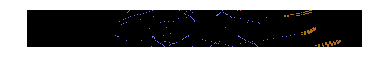

In [200]:
plt.figure(figsize = (6,6))
plt.axis("off")
plot_WF(WFset_ReLUf[0,:,:,0])